In [1]:
import integrand_interpolation as integrand
from interpolate_matrix import eps

import numpy as np
import matplotlib.pyplot as plt

To probe the effects of interpolation, we look to find $F_{\nu\nu} = T_1 - T_2$. Using initial conditions, where the density matrix is diagonal and the diagonal elements are the distribution functions.
The $T_1$, ("term 1") is the process that creates neutrinos $p_1$ and $T_2$ are the ones that scatter away.

Use thermal distributions with $\eta_e = 0.01$ and $\eta_\mu = -0.01$. For thermal distributions, we expect $F_{\nu\nu} = 0$.

First, we use the analytical forms to prove that $F_{\nu\nu} = 0$. Take 1000 random combinations of p1, p2, p3, p4 and calculate $F_{\nu\nu}$.

In [2]:
T1_vals = np.zeros(1000)
T2_vals = np.zeros(1000)

p = np.zeros(4)

for i in range(len(T1_vals)):
    p[0] = 10 * np.random.rand()
    p[1] = 10 * np.random.rand()
    p[2] = (p[0] + p[1]) * np.random.rand()
    p[3] = p[0] + p[1] - p[2]
    
    T1_vals[i], T2_vals[i] = integrand.Fvv_eq(p)

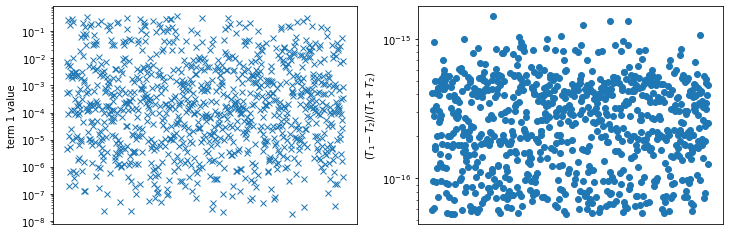

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12,4))
ax[0].semilogy(T1_vals, 'x')
ax[1].semilogy(np.abs(T1_vals-T2_vals)/(T1_vals+T2_vals), 'o')

ax[0].set_xticks([])
ax[0].set_ylabel("term 1 value")
ax[1].set_ylabel(r"$(T_1 - T_2)/(T_1 + T_2)$")
plt.show()

The graphs show the $T_1$ value on left, and on the right is the absolute value of $F_{\nu\nu} / (T_1 + T_2)$. The two terms do not perfectly cancel out, but they do so to the appropriate numerical accuracy of "zero".

Now, we look at an array of p1 values (``eps[5:201:10]`` and the Gauss-Laguerre points) and different p2 values (``eps[10:201:10]`` and the Gauss-Laguerre points), along with all the valid p3 values and resulting p4 values. **Avoiding** any usage of extrapolation.

Use interpolation on p4 values when needed to find the $F_{\nu\nu}$.

In [4]:
%%time
p_test = integrand.make_p_test(eps)
T1_test = np.zeros((2,len(p_test)))
T2_test = np.zeros_like(T1_test)

rho = integrand.int.dens_array(eps, integrand.f_FD_e, integrand.f_FD_m)

for i in range(len(p_test)):
    T1_test[0,i], T2_test[0,i] = integrand.Fvv_eq(p_test[i])
    fg = integrand.make_fg_interpolate(p_test[i], eps, rho)
    T1_test[1,i], T2_test[1,i] = integrand.Fvv(fg[0], fg[1])

CPU times: user 8.98 s, sys: 54.1 ms, total: 9.03 s
Wall time: 8.99 s


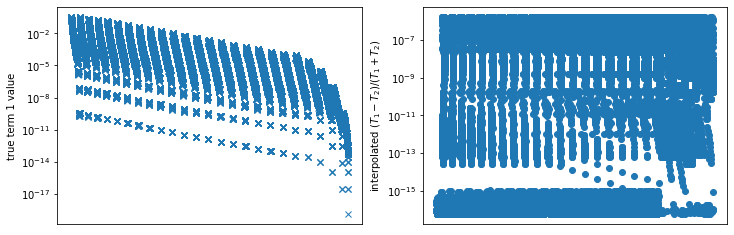

In [5]:
r1 = np.abs(T1_test[1,:]-T1_test[0,:])/(T1_test[1,:]+T1_test[0,:])
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12,4))
ax[0].semilogy(T1_test[0,:], 'x')
ax[1].semilogy(r1, 'o')

ax[0].set_xticks([])
ax[0].set_ylabel("true term 1 value")
ax[1].set_ylabel(r"interpolated $(T_1 - T_2)/(T_1 + T_2)$")
plt.show()

on the left is the "true" term 1, using the analytical form. On the right uses interpolation (when necessary) for p4. Once again, $F_{\nu\nu} = T_1 - T_2$ should be zero, so the right shows a relative error. Many points are $< 10^{-15}$ as with the analytic result, but many points are up to 8-9 orders of magnitude larger!

What makes the bad values, the ones where the relative errors are large? Below plot the (p1, p2, p3, p4) values which has a relative error $> 10^{-8}$ and $>10^{-6}$.

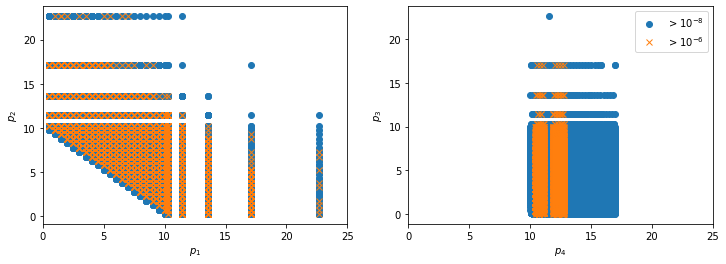

In [6]:
index_big = np.where(r1 > 1e-8)[0]
index_bigger = np.where(r1 > 1e-6)[0]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(p_test[index_big,0], p_test[index_big,1], 'o')
ax[0].plot(p_test[index_bigger,0], p_test[index_bigger,1], 'x')
ax[1].plot(p_test[index_big,3], p_test[index_big,2], 'o', label=r'$>10^{-8}$')
ax[1].plot(p_test[index_bigger,3], p_test[index_bigger,2], 'x', label=r'$>10^{-6}$')

ax[0].set_xlim([0,25])
ax[0].set_xlim([0,25])
ax[1].set_xlim([0,25])
ax[1].set_xlim([0,25])

ax[0].set_xlabel(r"$p_1$")
ax[0].set_ylabel(r"$p_2$")
ax[1].set_xlabel(r"$p_4$")
ax[1].set_ylabel(r"$p_3$")

ax[1].legend(loc='upper right')
plt.show()

The points with the worst error show up when $p_4 > 10$. This is where $p_4$ are in Gauss-Laguerre values and are always interpolated. The worst points are $10 < p_4 < 14$. The interpolation scheme works poorest in this region.